# Using fully with Python

`ecodynelec` offers the possibility to being fully used via Python. This tutorial shows different steps and possibilities, relying solely on operations doable within a python script or notebook. As the configuration of `ecodynelec` pipeline execution may benefit from more visual interaction, an alternative is suggested in the "[Using with a spreadsheet-based configuraion](https://ecodynelec.readthedocs.io/en/latest/examples/with_spreadsheet.html)" tutorial.

This is a simple use case of EcoDynelec, but a more complete example, using more features of EcoDynElec is available in the swiss_mix_analysis.ipynb notebook.

## Initialization

To download and install `ecodynelec` to being used as a python package, the user is referred to either the [getting started tutorial](https://ecodynelec.readthedocs.io/en/latest/examples/getting_started.html).

## Configuration

The configuration of `ecodynelec` is handled by the `parameter` module. 

In [1]:
from ecodynelec.parameter import Parameter # Import the class to manipulate parameters

Python is an object oriented language. Thus a specific configuration can be built and stored in a `Parameter` object that will be called `my_config` in this tutorial. The next cell only initializes the configuration object with the default parameters.

In [2]:
my_config = Parameter() # Initialize a configuration object

Before modifying the configuration, let's have a look at this default setting

In [3]:
print(my_config)

ctry --> ['AT', 'CH', 'CZ', 'DE', 'FR', 'IT']
target --> ['CH']
start --> 2017-02-01 00:00:00
end --> 2017-02-01 23:00:00
freq --> H
timezone --> UTC
cst_imports --> False
net_exchanges --> False
network_losses --> False
sg_imports --> False
residual_local --> False
residual_global --> False
data_cleaning --> True

Filepath to generation --> None
Filepath to exchanges --> None
Filepath to savedir --> None
Filepath to ui_vector --> None
Filepath to mapping --> None
Filepath to neighbours --> None
Filepath to gap --> None
Filepath to swissGrid --> None
Filepath to networkLosses --> None
 
Server for useServer --> False
Server for host --> sftp-transparency.entsoe.eu
Server for port --> 22
Server for username --> None
Server for password --> 
Server for removeUnused --> False
Server for _remoteGenerationDir --> /TP_export/AggregatedGenerationPerType_16.1.B_C/
Server for _remoteExchangesDir --> /TP_export/PhysicalFlows_12.1.G/



The configuration is composed of 3 parts. The detail about the meaning of each is developed in the [input data section](https://ecodynelec.readthedocs.io/en/latest/data_input/parameters.html). Essentially:
* the <u>first block</u> contains the elements to configure the execution itself. These elements are directly available and modifiable with the syntax `my_config.element`.
* the <u>second block</u> deals with all paths to information files, directory containing information, or where to write and save information before, during and after the computation. It is accessible with the syntax `my_config.path.element`
* the <u>third block</u> deals with information related to the ENTSO-E server, as electricity data from the ENTSO-E server is at the center of `ecodynelec`. More on this topic is covered on the next paragraph and on the dedicated [downloading tutorial](https://ecodynelec.readthedocs.io/en/latest/examples/downloading.html).

The next cell partly modifies the execution configuration.
* First the starting date is modified. Note that objects of the `Parameter` class will verify if this element is a date, and will raise an error if the format is not recognized.
* Then we modify the size of time step (frequency) for the computation. Possibilities are specified in the [input data section](https://ecodynelec.readthedocs.io/en/latest/data_input/parameters.html).
* Third in this example, the auto-completing feature is turned off.

In [5]:
## Change the starting date
my_config.start = '2017-02-01 00:00'

## Change the time step
my_config.freq = "15min"

## Change the coutry list
my_config.ctry = ['AT','CH','DE','FR','IT', 'CZ']

## Turn off the auto-complete
my_config.data_cleaning = False

The next cell partly modifies file path configuration. Here we modify the location of directories containing data downloaded from the ENTSO-E database.

In [6]:
# Indicate where to find generation data
my_config.path.generation = "./test_data/downloads/generations/"

# Indicate where to find exchange data
my_config.path.exchanges = "./test_data/downloads/exchanges/"

my_config.path.savedir = "./test_data/results/"

Note that, for the `generation`, `exchanges` and `savedir` paths, the specified directory *will be created if it does not already exist*. For every other file path element, *a default file* is used if nothing is specified, and an error is returned if the information passed does not correspond to any existing file on your local machine.

### Downloading Entso-E data

The [downloading tutorial](https://ecodynelec.readthedocs.io/en/latest/examples/downloading.html) covers the specificities about how to download the ENTSO-E data or include the download as part of the `ecodynelec` pipeline execution. This feature is not triggered per default and `ecodynelec` is expecting to find already downloaded ENTSO-E files.

## Execution

`ecodynelec` is build out of a myriad of modules that can be used relatively independently, under the condition that inputs data is shaped the correct way. Fortunately, the entire pipeline starting from a set of parameters and computing down to the calculation of impact metrics.

The usage of this entire pipeline is demonstrated below. This pipeline allows to save results into files (c.f. paragraph on [configuration](https://ecodynelec.readthedocs.io/en/latest/examples/with_python.html#configuration)). However results are also always returned for further in-script use. These results are stored in the `impacts` variable for later paragraphs in this tutorial.

In [7]:
from ecodynelec.pipelines import execute
from ecodynelec.progress_info import ProgressInfo

In [8]:
impacts = execute(config=my_config, progress_bar=ProgressInfo())

## Outcome and Visualization

The outcome is stored in files and returned for further in-script use. In the previous section, results were stored in the `impacts` variable. The current section highlights the content returned and shows some basic possibilities for data visualization.

In [9]:
import numpy as np
import pandas as pd

### Description of the outcome

The `impacts` variable contains a collection of tables. This collection is a `dict` with one `Global` key, and one other key per impact category:

In [10]:
print(impacts.keys())

dict_keys(['Global', 'Carbon intensity', 'Human carcinogenic toxicity', 'Fine particulate matter formation', 'Land use'])


The `Global` table is the *sum across all technologies* for each index, as it is shown for the first few time steps:

In [11]:
display(impacts['Global'].head())

,Carbon intensity,Human carcinogenic toxicity,Fine particulate matter formation,Land use
2017-02-01 00:00:00,0.465653,0.031056,0.000361,0.007320
2017-02-01 00:15:00,0.464645,0.031056,0.000360,0.007308
2017-02-01 00:30:00,0.464380,0.031102,0.000360,0.007294
2017-02-01 00:45:00,0.461740,0.031029,0.000355,0.007256
2017-02-01 01:00:00,0.462075,0.031102,0.000356,0.007232


The other tables are, for each impact category, the breakdown into all possible sources:

In [12]:
for i in impacts: # Iterate for all impact categories
    if i=='Global': continue; # Skip the Global, already visualized above.
    
    print(f"#############\nimpacts for {i}:")
    display( impacts[i].head(3).T ) # Transpose table for readability

#############
impacts for Carbon intensity:


,2017-02-01 00:00:00,2017-02-01 00:15:00,2017-02-01 00:30:00
Carbon intensity_source,,,
Mix_Other,0.007879,0.007885,0.007868
Biomass_AT,0.000330,0.000325,0.000317
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.018303,0.017538,0.016997
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


#############
impacts for Human carcinogenic toxicity:


,2017-02-01 00:00:00,2017-02-01 00:15:00,2017-02-01 00:30:00
Human carcinogenic toxicity_source,,,
Mix_Other,0.000525,0.000526,0.000525
Biomass_AT,0.000023,0.000022,0.000022
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.000132,0.000126,0.000122
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


#############
impacts for Fine particulate matter formation:


,2017-02-01 00:00:00,2017-02-01 00:15:00,2017-02-01 00:30:00
Fine particulate matter formation_source,,,
Mix_Other,0.000012,0.000012,0.000012
Biomass_AT,0.000001,0.000001,0.000001
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.000006,0.000006,0.000005
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


#############
impacts for Land use:


,2017-02-01 00:00:00,2017-02-01 00:15:00,2017-02-01 00:30:00
Land use_source,,,
Mix_Other,0.000227,0.000227,0.000226
Biomass_AT,0.001014,0.000997,0.000974
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.000068,0.000065,0.000063
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


### Group per country

The following piece of code suggests a basic visualization of the Climate Change category, grouping the results per country of origin of the tracked electricity.

In [14]:
impacts['Carbon intensity'].columns

Index(['Mix_Other', 'Biomass_AT', 'Fossil_Brown_coal/Lignite_AT',
       'Fossil_Coal-derived_gas_AT', 'Fossil_Gas_AT', 'Fossil_Hard_coal_AT',
       'Fossil_Oil_AT', 'Fossil_Oil_shale_AT', 'Fossil_Peat_AT',
       'Geothermal_AT',
       ...
       'Hydro_Run-of-river_and_poundage_IT', 'Hydro_Water_Reservoir_IT',
       'Marine_IT', 'Nuclear_IT', 'Other_fossil_IT', 'Other_renewable_IT',
       'Solar_IT', 'Waste_IT', 'Wind_Offshore_IT', 'Wind_Onshore_IT'],
      dtype='object', name='Carbon intensity_source', length=121)

In [15]:
# Filters the CH
cli = impacts['Carbon intensity']
lcs = cli.loc[:,[not src.endswith('_CH') for src in cli.columns]]
cli2 = cli.drop(lcs, axis=1)

In [16]:
cli2.keys()

Index(['Biomass_CH', 'Fossil_Brown_coal/Lignite_CH',
       'Fossil_Coal-derived_gas_CH', 'Fossil_Gas_CH', 'Fossil_Hard_coal_CH',
       'Fossil_Oil_CH', 'Fossil_Oil_shale_CH', 'Fossil_Peat_CH',
       'Geothermal_CH', 'Hydro_Pumped_Storage_CH',
       'Hydro_Run-of-river_and_poundage_CH', 'Hydro_Water_Reservoir_CH',
       'Marine_CH', 'Nuclear_CH', 'Other_fossil_CH', 'Other_renewable_CH',
       'Solar_CH', 'Waste_CH', 'Wind_Offshore_CH', 'Wind_Onshore_CH'],
      dtype='object', name='Carbon intensity_source')

In [17]:
def compute_per_country(results):
    """Function to group results per country"""
    countries = np.unique([c.split("_")[-1] for c in results.columns]) # List of countries
    
    per_country = []
    for c in countries:
        cols = [k for k in results.columns if k[-3:]==f"_{c}"]
        per_country.append(pd.Series(results.loc[:,cols].sum(axis=1), name=c))
        
    return pd.concat(per_country,axis=1)

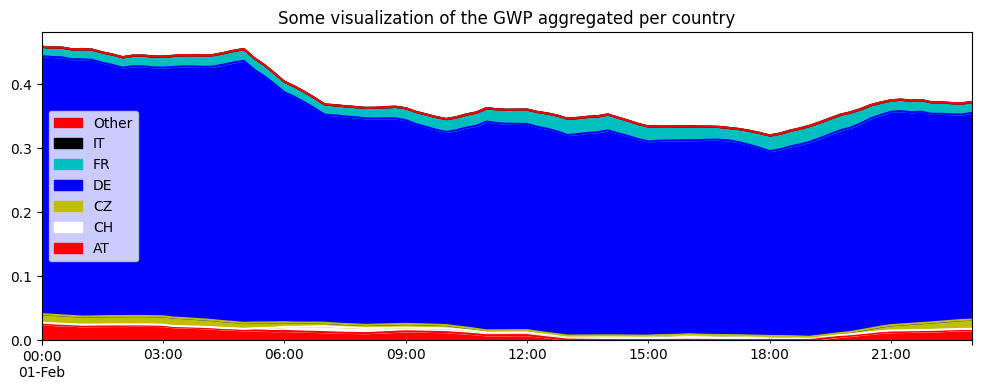

In [18]:
import numpy as np
import pandas as pd

gwp_per_country = compute_per_country(impacts['Carbon intensity']) # Group Carbon intensity index impacts per country
gwp_per_country.plot.area(figsize=(12,4), legend='reverse', color=['r','w','y','b','c','k'],
                          title="Some visualization of the GWP aggregated per country"); # Build the graph

### Group per production type

The following piece of code suggests a basic visualization of the Carbon intensity category, grouping the results per technology of origin of the tracked electricity.

In [20]:
impacts.keys()

dict_keys(['Global', 'Carbon intensity', 'Human carcinogenic toxicity', 'Fine particulate matter formation', 'Land use'])

In [21]:
def compute_per_type(results):
    """Function to group datasets per type of unit, regardless of the country of origin"""
    unit_list = np.unique([k[:-3] if k[-3]=="_" else k for k in results.columns]) # List the different production units
    
    per_unit = []
    for u in unit_list:
        cols = [k for k in results.columns if k[:-3]==u] # collect the useful columns
        per_unit.append(pd.Series(results.loc[:,cols].sum(axis=1), name=u)) # aggregate

    return pd.concat(per_unit,axis=1)

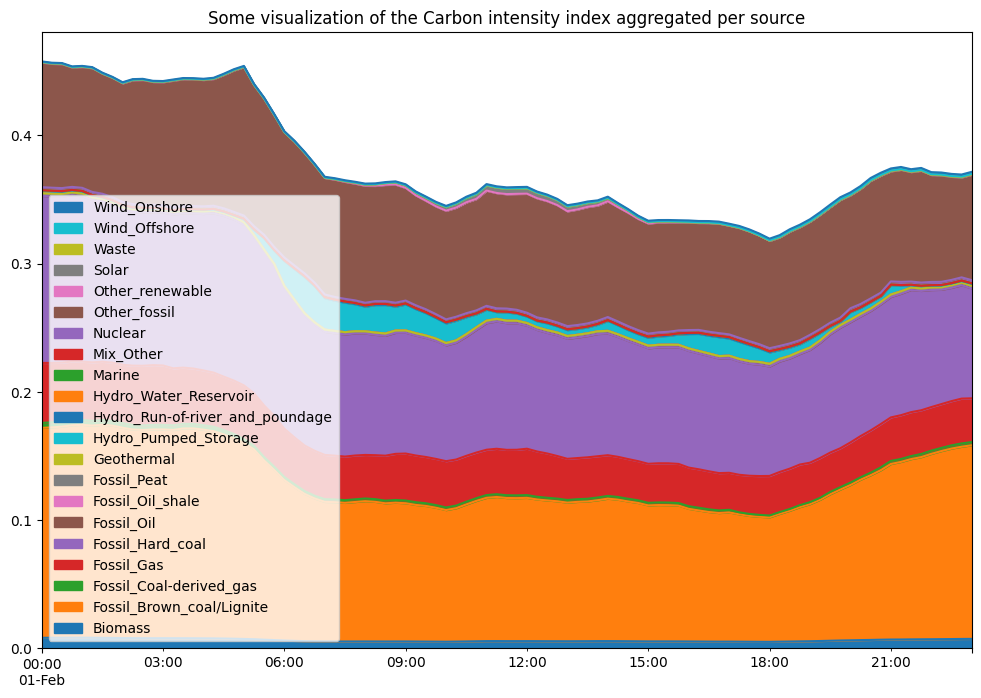

In [22]:
es13_per_type = compute_per_type(impacts['Carbon intensity']) # Group Carbon intensity index impacts per country
es13_per_type.plot.area(figsize=(12,8), legend='reverse',
                        title="Some visualization of the Carbon intensity index aggregated per source"); # Build the graph